In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape, Conv1D, Conv1DTranspose, MaxPooling1D, TimeDistributed, Flatten, UpSampling1D, LSTM
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import mse, Huber
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

from shared import read_dataset, plot_results, evaluate_price_predictions, mean_abs_error

#Trading Days: (2286, 6)


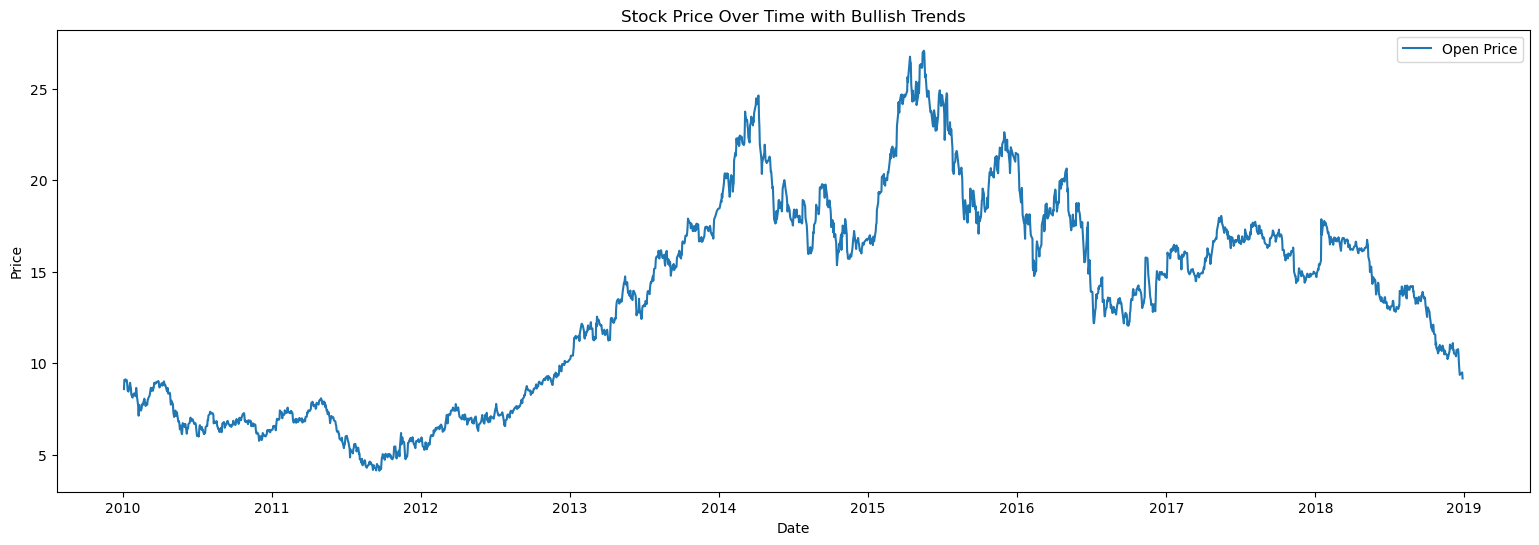

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [5]:
start = "2010-01-01"
end = "2019-01-01"
target_column_name = 'Open'
path = '../models/lstm_model/predictor_adj_close.h5'

AZM = read_dataset('../data/AZM.MI.csv', start, end)

data = AZM
data = data.drop('High Diff', axis=1)
data = data.drop('Low Diff', axis=1)

data.dropna(inplace=True)

cols = [target_column_name] + [ col for col in data if col != target_column_name]
target_column = list(data.columns).index(target_column_name)
data = data[cols]

print(f"#Trading Days: {data.shape}")

plt.figure(figsize=(19, 6))
plt.plot(data[target_column_name], label='Open Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Over Time with Bullish Trends')
plt.legend()
plt.show()
print(cols)

In [18]:
SEQUENCE_LENGTH = 40
PREDICTION_SHIFT= 0
NUM_FEATURES = data.shape[-1]

# Define feature array and target array to train the model.
data_array = np.array(data.values)
# target will be the data itself

# Normalize the data
scaler_data = MinMaxScaler()
scaler_data.fit(data_array)
data_array = scaler_data.transform(data_array)

def create_sequences(data, seq_length):
    sequence_data = []
    for i in range(seq_length, len(data)-PREDICTION_SHIFT):
        sequence_data.append(data[i-seq_length:i])
    return np.array(sequence_data)

data_sequences = create_sequences(data_array, SEQUENCE_LENGTH)

# Split the data
train_size = int(data_sequences.shape[0]* 0.9)
evaluation_size = int(0) # no evaluation


train_data, validation_data, test_data = data_sequences[:train_size], data_sequences[train_size:train_size+evaluation_size], data_sequences[train_size+evaluation_size:]

# train_data = train_data.reshape(train_data.shape[0], 1, SEQUENCE_LENGTH, NUM_FEATURES)
# validation_data = validation_data.reshape(validation_data.shape[0], 1,SEQUENCE_LENGTH, NUM_FEATURES)
# test_data = test_data.reshape(test_data.shape[0], 1,SEQUENCE_LENGTH, NUM_FEATURES)

print(f"Train | data: {train_data.shape}")
print(f"Valid | data: {validation_data.shape}")
print(f"Testt | data: {test_data.shape}")


Train | data: (2021, 40, 6)
Valid | data: (0, 40, 6)
Testt | data: (225, 40, 6)


In [ ]:
first_conv_size = 64
second_conv_size = 128
third_conv_size = 256

def build_encoder(seq_length, num_features, latent_dim):
    l2_value = 0.003
    
    model = Sequential()
    model.add(TimeDistributed(Conv1D(first_conv_size, kernel_size=3, activation='selu', input_shape=(seq_length, num_features),
        bias_regularizer=l2(l2_value), kernel_regularizer=l2(l2_value),
        )))
    model.add(TimeDistributed(MaxPooling1D(2)))

    model.add(TimeDistributed(Conv1D(second_conv_size, kernel_size=3, activation='selu',
        bias_regularizer=l2(l2_value), kernel_regularizer=l2(l2_value),
    )))
    model.add(TimeDistributed(MaxPooling1D(2)))

    model.add(TimeDistributed(Conv1D(third_conv_size, kernel_size=3, activation='selu',
        bias_regularizer=l2(l2_value), kernel_regularizer=l2(l2_value),
    )))
    model.add(TimeDistributed(MaxPooling1D(2)))
    
    model.add(Transformer(num_layers = 2, d_model=first_conv_size, )
    model.add(TimeDistributed(Flatten()))
    model.add(Dense(latent_dim + latent_dim))

    input_layer = Input(shape=(1, seq_length, num_features))
    encoder_output = model(input_layer)

    z_mean = LSTM(latent_dim)(encoder_output)
    z_log_var = LSTM(latent_dim)(encoder_output)

    return Model(input_layer, [z_mean, z_log_var]), z_mean, z_log_var

def build_decoder(latent_dim, final_shape, num_features):
    l2_value = 0.003
    model = Sequential()
    model.add(Dense(units=np.prod(final_shape[1:]), activation='relu', input_dim=latent_dim))
    model.add(Reshape(final_shape))

    model.add(TimeDistributed(Conv1DTranspose(third_conv_size, kernel_size=3, padding='same', activation='selu',
                                            bias_regularizer=l2(l2_value), kernel_regularizer=l2(l2_value))))
    model.add(TimeDistributed(UpSampling1D(2)))
    model.add(TimeDistributed(Conv1DTranspose(second_conv_size, kernel_size=3, padding='same', activation='selu',
                                            bias_regularizer=l2(l2_value), kernel_regularizer=l2(l2_value))))
    model.add(TimeDistributed(UpSampling1D(2)))
    model.add(TimeDistributed(Conv1DTranspose(first_conv_size, kernel_size=3, padding='same', activation='selu',
                                            bias_regularizer=l2(l2_value), kernel_regularizer=l2(l2_value))))
    model.add(TimeDistributed(UpSampling1D(2)))
    model.add(TimeDistributed(Dense(num_features)))
    z = Input(shape=(latent_dim,))
    decoded_output = model(z)

    return Model(z, decoded_output)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def build_vae(encoder, decoder, seq_length, num_features, latent_dim):
    inputs = Input(shape=(1, seq_length, num_features))
    z_mean, z_log_var = encoder(inputs)

    z_mean_flat = Flatten()(z_mean)
    z_log_var_flat = Flatten()(z_log_var)

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean_flat, z_log_var_flat])
    reconstructed = decoder(z)
    
    vae = Model(inputs, reconstructed)

    alpha = 1
    beta = 1

    reconstruction_loss = mse(K.flatten(inputs), K.flatten(reconstructed))
    reconstruction_loss *= seq_length * num_features
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(alpha * reconstruction_loss + beta * kl_loss)
    vae.add_loss(vae_loss)

    return vae

def train_vae(vae, X_train, epochs=40, batch_size=40, patience=10):
    vae.compile(optimizer=AdamW())

    print("Output shape:", vae.output_shape)
    print("Target shape:", X_train.shape)
    
    vae.fit(X_train, X_train,  # target is the same as input
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=patience, verbose=2, mode='min', restore_best_weights=True)])


In [ ]:
latent_dim = 50

print(f'SEQUENCE_LENGTH= {SEQUENCE_LENGTH}')
print(f'NUM_FEATURES = {NUM_FEATURES}')

encoder, z_mean, z_log_var = build_encoder(SEQUENCE_LENGTH, NUM_FEATURES, latent_dim)
final_shape = (1, SEQUENCE_LENGTH // 8, NUM_FEATURES)
decoder = build_decoder(latent_dim, final_shape, NUM_FEATURES)

print(f'Encoder Input: {encoder.input_shape}')
print(f'Encoder Output: {encoder.output_shape}')
print(f'Decoder Input: {decoder.input_shape}')
print(f'Decoder Output: {decoder.output_shape}')

vae = build_vae(encoder, decoder, SEQUENCE_LENGTH, NUM_FEATURES, latent_dim)
train_vae(vae, train_data, epochs=8000, batch_size=1000, patience=100) # the target is the same as the input as I want the VAE to capture the data input structure.

In [24]:
# transformer VAE

latent_dim = 50
first_conv_size = 64

def build_attention_encoder(seq_length, num_features, latent_dim):
    l2_value = 0.003
    
    input_layer = Input(shape=(seq_length, num_features))
    attention_output = MultiHeadAttention(num_heads=2, key_dim=first_conv_size)(input_layer, input_layer, input_layer)
    
    flattened = TimeDistributed(Flatten())(attention_output)
    dense_output = Dense(latent_dim + latent_dim)(flattened)

    z_mean = LSTM(latent_dim)(dense_output)
    z_log_var = LSTM(latent_dim)(dense_output)

    return Model(input_layer, [z_mean, z_log_var]), z_mean, z_log_var

def build_attention_decoder(latent_dim, seq_length, num_features):
    l2_value = 0.003

    model = Sequential()
    model.add(Dense(units=seq_length * num_features, activation='relu', input_dim=latent_dim))
    model.add(Reshape((seq_length, num_features)))

    model.add(MultiHeadAttention(num_heads=2, key_dim=first_conv_size))
    
    model.add(TimeDistributed(Dense(num_features)))
    z = Input(shape=(latent_dim,))
    decoded_output = model(z)

    return Model(z, decoded_output)

def build_attention_vae(encoder, decoder, seq_length, num_features, latent_dim):
    inputs = Input(shape=(seq_length, num_features))
    z_mean, z_log_var = encoder(inputs)

    z_mean_flat = Flatten()(z_mean)
    z_log_var_flat = Flatten()(z_log_var)

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean_flat, z_log_var_flat])
    reconstructed = decoder(z)
    
    vae = Model(inputs, reconstructed)

    alpha = 1
    beta = 1

    reconstruction_loss = mse(K.flatten(inputs), K.flatten(reconstructed))
    reconstruction_loss *= seq_length * num_features
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(alpha * reconstruction_loss + beta * kl_loss)
    vae.add_loss(vae_loss)

    return vae

def train_attention_vae(vae, X_train, epochs=40, batch_size=40, patience=10):
    vae.compile(optimizer=AdamW())

    print("Output shape:", vae.output_shape)
    print("Target shape:", X_train.shape)
    
    vae.fit(X_train, X_train,  # target is the same as input
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=patience, verbose=1)])


In [25]:
print(f'SEQUENCE_LENGTH= {SEQUENCE_LENGTH}')
print(f'NUM_FEATURES = {NUM_FEATURES}')

encoder, z_mean, z_log_var = build_attention_encoder(SEQUENCE_LENGTH, NUM_FEATURES, latent_dim)
decoder = build_attention_decoder(latent_dim, SEQUENCE_LENGTH, NUM_FEATURES)

print(f'Encoder Input: {encoder.input_shape}')
print(f'Encoder Output: {encoder.output_shape}')
print(f'Decoder Input: {decoder.input_shape}')
print(f'Decoder Output: {decoder.output_shape}')

vae = build_attention_vae(encoder, decoder, SEQUENCE_LENGTH, NUM_FEATURES, latent_dim)
train_attention_vae(vae, train_data, epochs=8000, batch_size=1000, patience=100)


SEQUENCE_LENGTH= 40
NUM_FEATURES = 6


TypeError: MultiHeadAttention.call() missing 1 required positional argument: 'value'

In [ ]:
vae.evaluate(test_data)